In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.5 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=eb0f8f1b17969517c2e61cdd96043b40d5e4def83cf39dcb7be24268cc899f50
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import (
    ArrayType, IntegerType, FloatType, 
    DoubleType, StringType, TimestampType)

from pyspark.sql.functions import (
    sum, col, count, length, size, split,
    udf, when, isnan, explode, array_min,
    array_max, array_distinct, to_timestamp,
    explode, countDistinct, mean, year, month
)

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

from tabulate import tabulate

In [3]:
spark = SparkSession \
    .builder \
    .config("spark.driver.memory", "20g") \
    .config("spark.driver.maxResultSize", "10g") \
    .config("spark.jars", "postgresql-42.6.0.jar") \
    .appName("Yelp Review Sense - EDA - Business") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/04 00:46:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# Define the JDBC connection details
jdbc_url = "jdbc:postgresql://intentionally-removed.amazonaws.com/yelpreviewsense"
db_table = ""
db_user = "postgres"
db_password = ""

# Specify the read options
read_options = {
    "url": jdbc_url,
    "driver": "org.postgresql.Driver",
    "dbtable": f"""
        (SELECT
            user_id,
            user_yelping_since,
            user_review_count,
            user_average_stars,
            user_fans,
            user_friends_count,
            user_total_interactions,
            user_total_compliments,
            user_elite_years_count,
            user_elite_min_year,
            user_elite_max_year
        FROM {db_table}) AS user_data
    """,
    "user": db_user,
    "password": db_password,
}

# Read the table into a PySpark DataFrame
df = spark.read.format("jdbc").options(**read_options).load()
df.limit(5).toPandas()

,user_id,user_yelping_since,user_review_count,user_average_stars,user_fans,user_friends_count,user_total_interactions,user_total_compliments,user_elite_years_count,user_elite_min_year,user_elite_max_year
0,qVc8ODYU5SZjKXVBgXdI7w,2007-01-25 16:47:26,585,3.91,267,14995,14470,2873,1,2007,2007
1,j14WgRoU_-2ZE1aw1dXrJg,2009-01-25 04:35:42,4333,3.74,3138,4646,83438,20631,14,20,2021
2,2WnXYQFK0hXEoTxPtV2zvg,2008-07-25 10:41:00,665,3.32,52,381,4099,585,5,2009,2013
3,SZDeASXq7o05mMNLshsdIA,2005-11-29 04:38:33,224,4.27,28,131,1141,136,3,2009,2011
4,hA5lMy-EnncsH4JoR-hFGQ,2007-01-05 19:40:59,79,3.54,1,27,51,4,0,0,0


In [5]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas()

,user_id,user_yelping_since,user_review_count,user_average_stars,user_fans,user_friends_count,user_total_interactions,user_total_compliments,user_elite_years_count,user_elite_min_year,user_elite_max_year
0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
df.describe().toPandas()

23/12/04 00:46:25 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,summary,user_id,user_review_count,user_average_stars,user_fans,user_friends_count,user_total_interactions,user_total_compliments,user_elite_years_count,user_elite_min_year,user_elite_max_year
0,count,1987897,1987897,1987897,1987897,1987897,1987897,1987897,1987897,1987897,1987897
1,mean,None,23.394409267683386,3.6304941503489485,1.4657404282012598,53.375011381374385,83.05978529068659,14.873109119838704,0.1914062951953748,52.357344470060575,92.37674839289963
2,stddev,None,82.56699161797467,1.1833369995975458,18.13075272385477,146.44346945442766,1600.320254133563,547.1340564547802,1.054780336230679,319.26920733008285,421.79974321656704
3,min,---1lKK3aKOuomHnwAkAow,0,1.0,0,1,0,0,0,0,0
4,max,zzzUFM4HFe0SFG0bPjntQA,17473,5.0,12497,14995,587933,324328,17,2021,2021


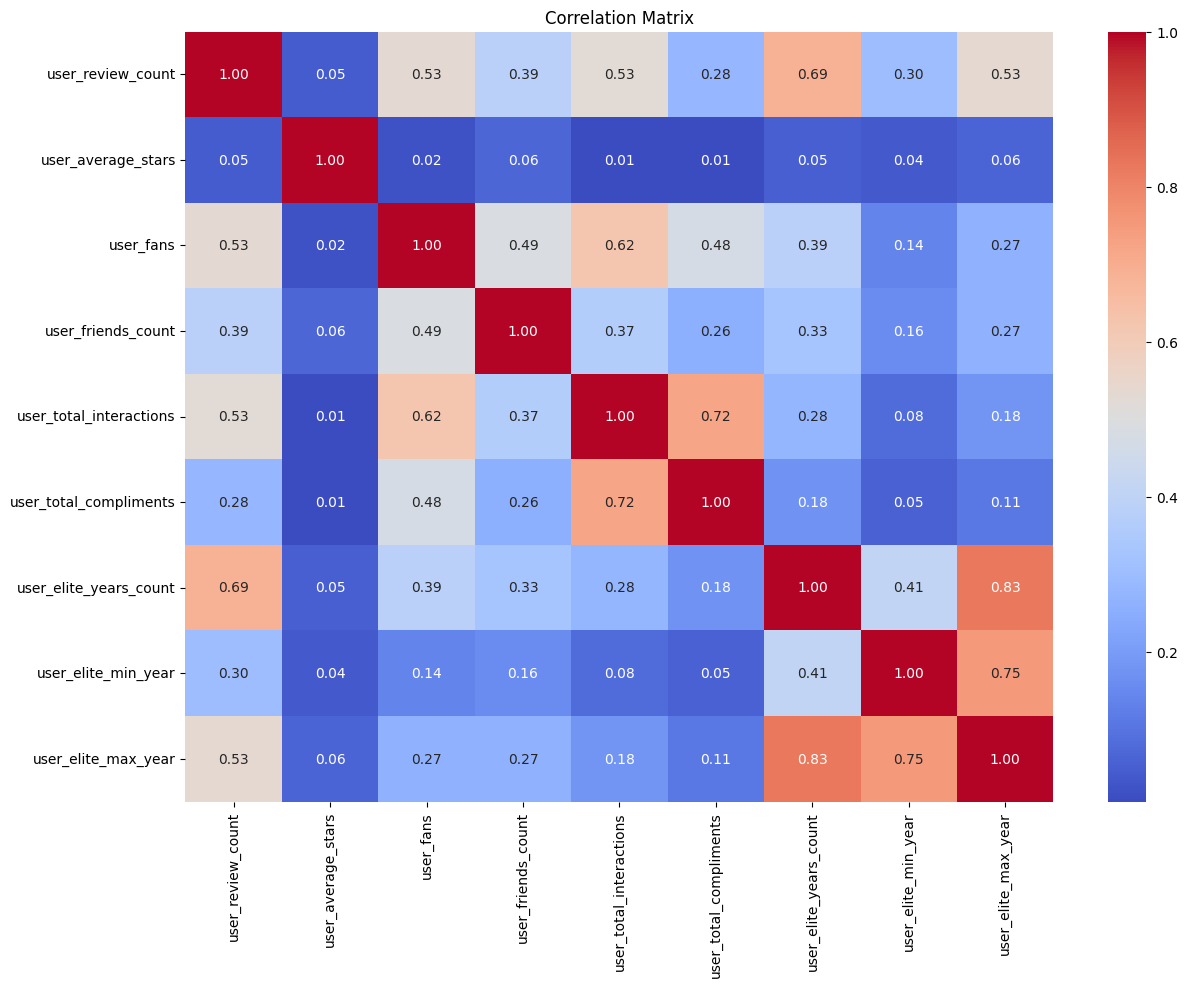

In [7]:
# Correlation matrix

numerical_cols = [col_name for col_name, col_type in df.dtypes if col_type in ['int', 'float', 'double']]
correlation_matrix = df.select([col(c).cast("float") for c in numerical_cols]).toPandas().corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

Some key observations and inferences from the correlation matrix are:

* The user review count demonstrates strong positive correlations with user fans (0.53) and user total interactions (0.53). This suggests that users who contribute more reviews tend to attract a larger fan base and review interactions.

* The user's elite status, as indicated by the count of elite years, shows a strong positive correlation with the user's review count (0.69). This suggests that users who have been elite for multiple years tend to be more active in writing reviews.

* User Total Interactions and User Total Compliments show a substantial positive correlation (0.72), suggesting that users who receive more interactions also tend to receive more compliments.

* User fans and user friends count are positively correlated (0.49), suggesting that users with more friends on the platform are likely to have more fans as well.

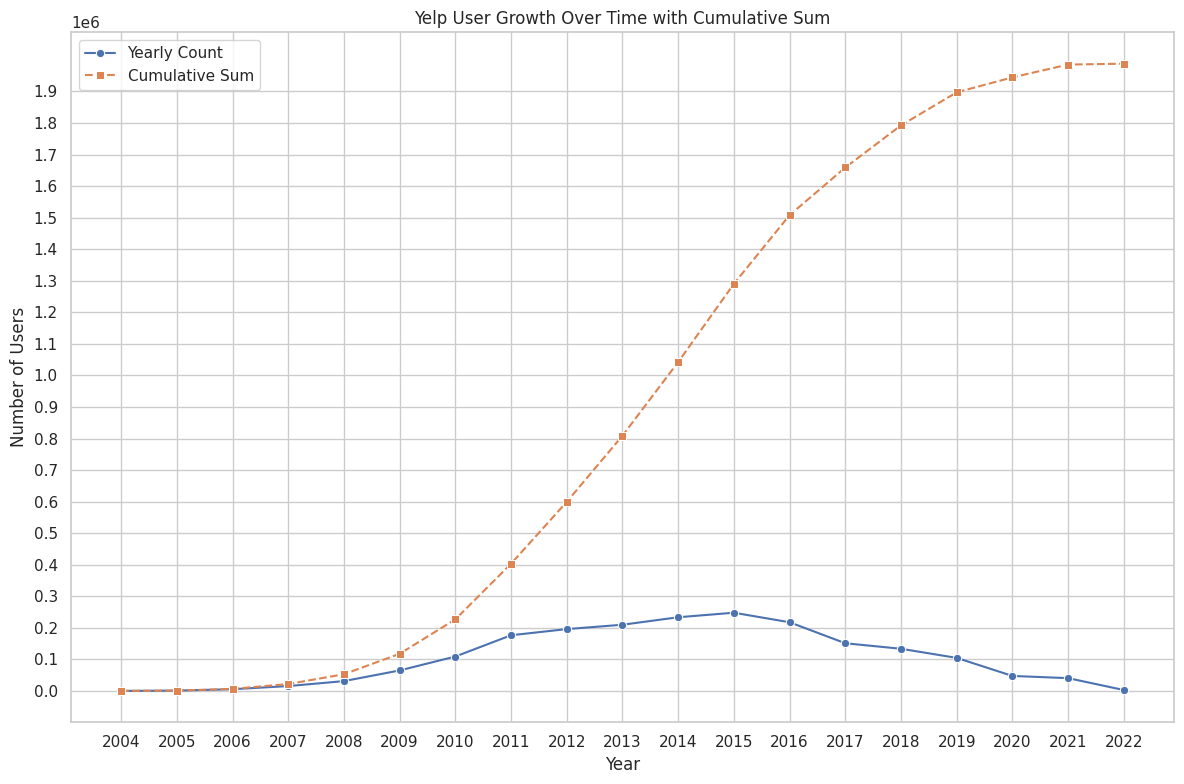

In [8]:
# Analyzing Yelp user activity over time with cumulative sum

selected_columns = [
    'user_yelping_since',
    'user_elite_years_count'
]

user_activity_df = df.select(selected_columns).toPandas()

user_activity_df['user_yelping_since'] = pd.to_datetime(user_activity_df['user_yelping_since'])
user_activity_df['yelping_year'] = user_activity_df['user_yelping_since'].dt.year
activity_over_time = user_activity_df.groupby('yelping_year').size().reset_index(name='count')
activity_over_time['cumulative_sum'] = activity_over_time['count'].cumsum()

sns.set(style='whitegrid')
plt.figure(figsize=(12, 8))

ax = sns.lineplot(data=activity_over_time, x='yelping_year', y='count', marker='o', label='Yearly Count')
sns.lineplot(data=activity_over_time, x='yelping_year', y='cumulative_sum', marker='s', linestyle='--', label='Cumulative Sum')
plt.title('Yelp User Growth Over Time with Cumulative Sum')
plt.xlabel('Year')
plt.ylabel('Number of Users')

plt.xticks(range(activity_over_time['yelping_year'].min(), activity_over_time['yelping_year'].max() + 1))
plt.yticks(range(0, max(activity_over_time['cumulative_sum'])+1, 100000))
plt.legend()

plt.tight_layout()
plt.show()

The analysis of Yelp user activity over time reveals the following:

* **Early Growth and Establishment (2004-2007)**: In the initial years (2004-2007), Yelp witnessed a steady increase in user activity. This period marked the platform's early growth phase, attracting a substantial number of users who began contributing reviews and engaging with the community.

* **Explosive Growth (2008-2013)**: The years 2008 to 2013 witnessed exponential growth in Yelp user activity. The cumulative sum graph demonstrates a steep upward trajectory, indicating a significant influx of new users each year. This period depicts the platform's expansion and increasing popularity.

* **Stabilization and Maturity (2014 Onward)**: Starting from 2014, the growth rate of Yelp user activity shows signs of stabilization. While the yearly count remains substantial, the cumulative sum graph exhibits a less steep slope, suggesting a maturing user base. This phase may indicate that Yelp has reached a point where it continues to attract new users, but at a more sustainable rate.

* **Impact of External Factors (2020)**: A subtle decline during 2020 and 2021 is likely linked to the global impact of the COVID-19 pandemic, which could have exerted influence on user behavior and engagement patterns.

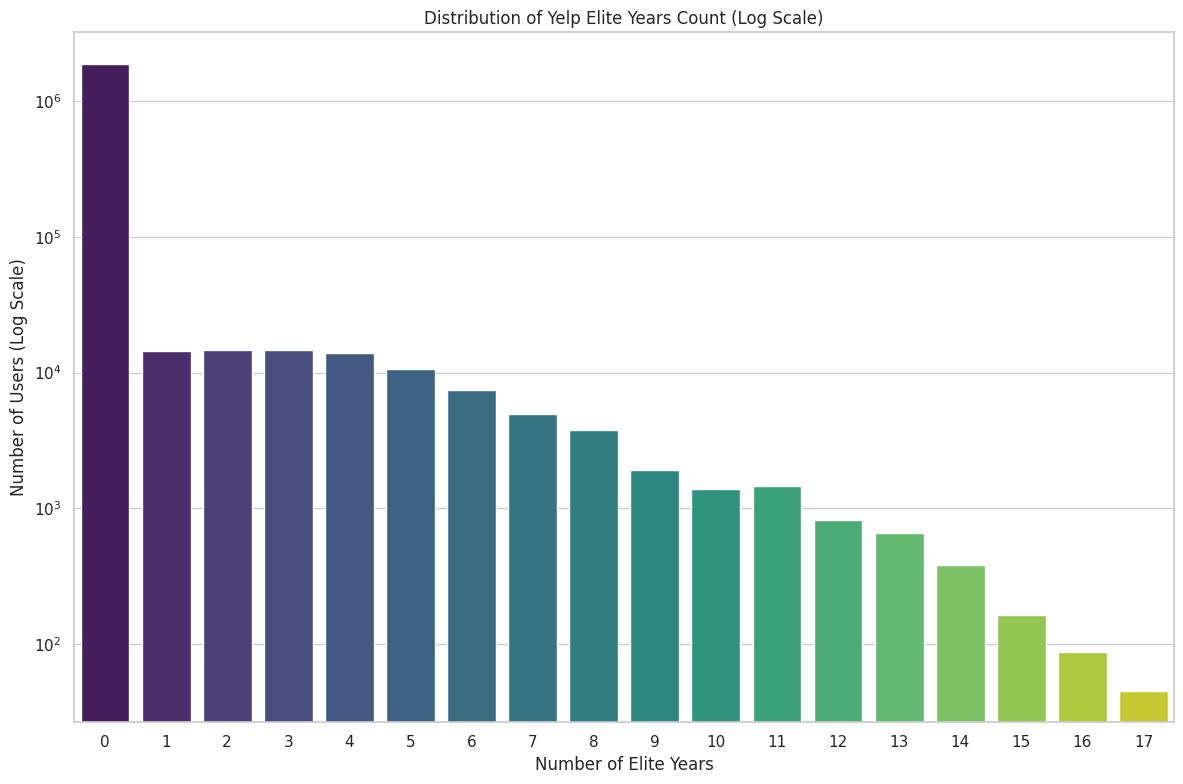

In [9]:
# Exploring the distribution of Yelp Elite Years Count

elite_years_distribution = user_activity_df['user_elite_years_count'].value_counts().sort_index().reset_index()
elite_years_distribution.columns = ['user_elite_years_count', 'count']

sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

sns.barplot(x='user_elite_years_count', y='count', data=elite_years_distribution, palette='viridis')
plt.title('Distribution of Yelp Elite Years Count (Log Scale)')
plt.xlabel('Number of Elite Years')
plt.ylabel('Number of Users (Log Scale)')
plt.yscale('log')

plt.tight_layout()
plt.show()

Here are key observations derived from the above distribution:

* The majority of Yelp users have not achieved elite status, indicating that a significant portion of the user base does not actively participate in or contribute to Yelp's elite program.

* As the number of elite years increases, the count of users gradually decreases. This trend suggests that fewer users maintain elite status for extended periods, potentially indicating a level of exclusivity or selectivity in retaining elite standing over time

* There is a noticeable concentration of users with lower elite years counts, particularly in the range of 1 to 5 elite years. This suggests that a considerable number of users achieve elite status for shorter durations, possibly engaging with the program intermittently.

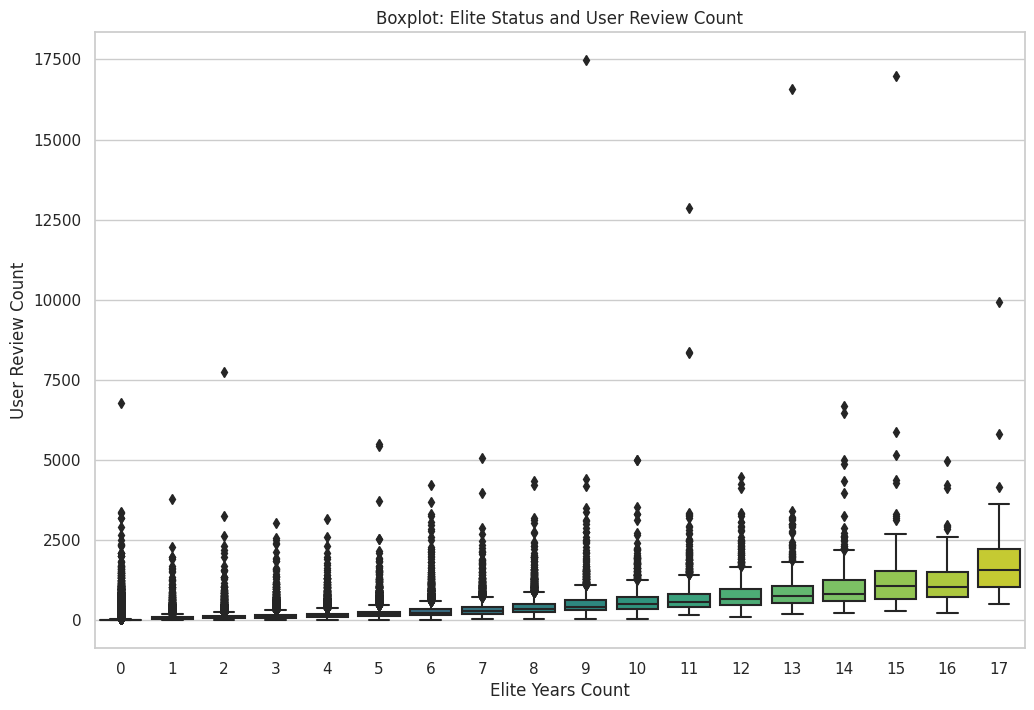

In [10]:
# Exploring the relationship between Elite Status (years) and User Review Count

selected_columns = [
    'user_elite_years_count',
    'user_review_count'
]

elite_status_df = df.select(selected_columns).toPandas()

sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

sns.boxplot(x="user_elite_years_count", y="user_review_count", data=elite_status_df, palette='viridis')
plt.title('Boxplot: Elite Status and User Review Count')
plt.xlabel('Elite Years Count')
plt.ylabel('User Review Count')

plt.tight_layout()
plt.show()

The boxplot sheds light on the following:

* Users with elite status generally exhibit higher median and mean review counts. As the number of elite years increases, there is a corresponding increase in the median and mean review counts. This suggests a positive correlation between elite status and user engagement, with elite users contributing more reviews on average.

* The spread of review counts becomes more pronounced for users with higher elite years count. This is evident in the widening IQR and increasing variability in the upper percentiles, indicating that some elite users contribute a significantly higher number of reviews.

* Notably, there are outliers in each elite years count category, especially for users with higher elite status. These outliers represent individuals who significantly exceed the typical review counts, contributing to the substantial standard deviations observed in those categories.

* The analysis underscores the positive association between elite status and increased user engagement, emphasizing the potential value of Yelp's elite recognition programs in fostering active and prolific contributors.

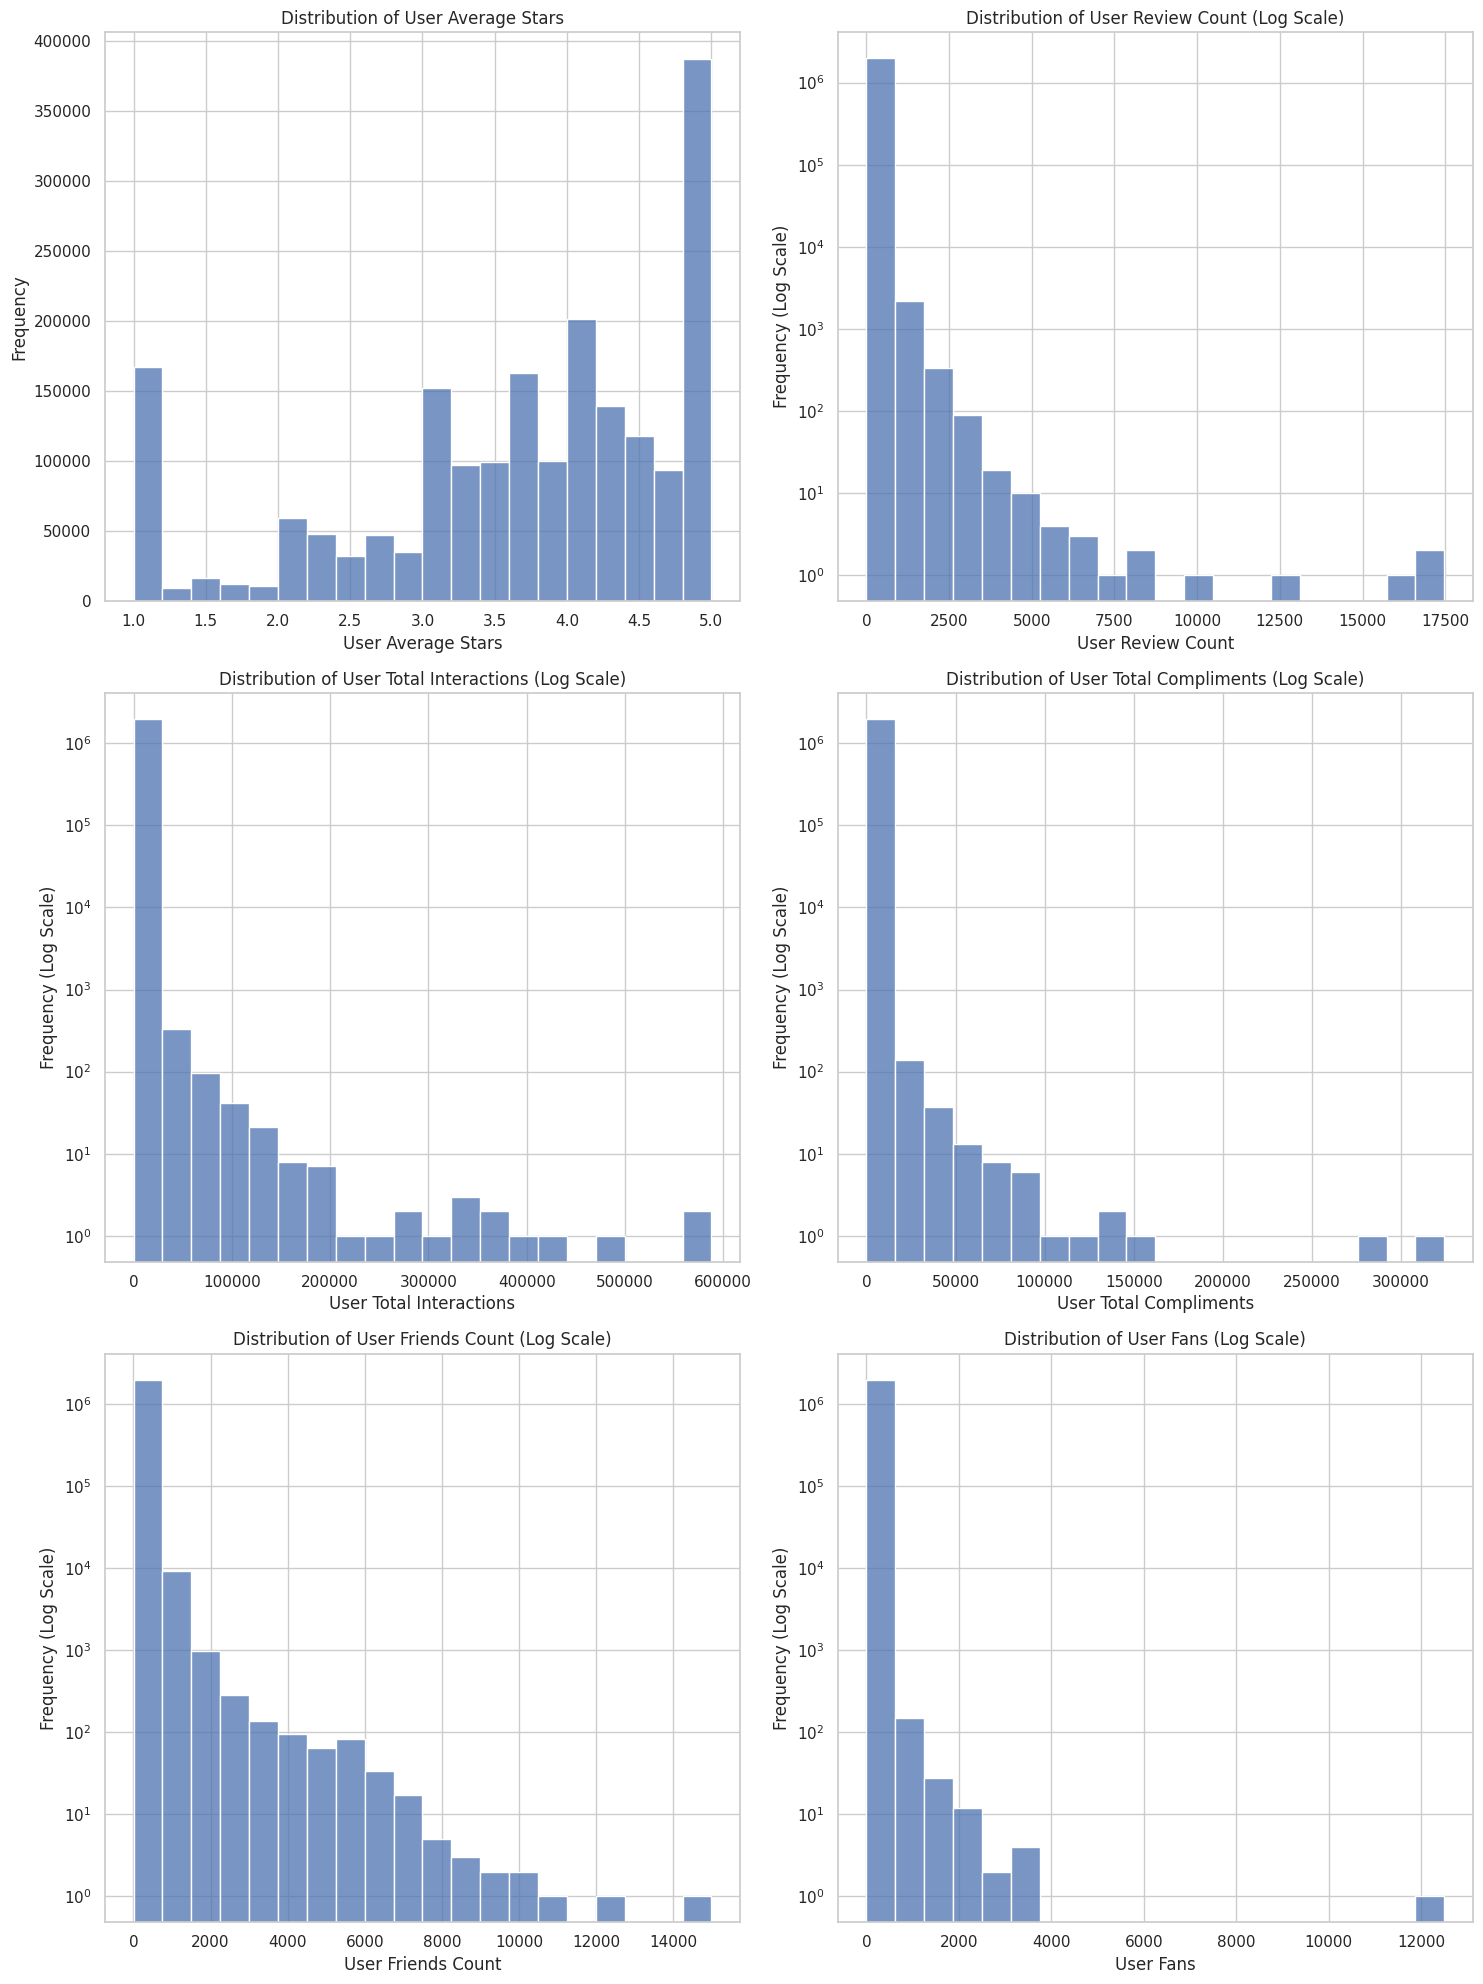

In [11]:
# Exploring the distribution of various user-related metrics 

selected_columns = [
    'user_average_stars',
    'user_review_count',
    'user_total_interactions',
    'user_total_compliments',
    'user_friends_count',
    'user_fans'
]

user_analysis_df = df.select(selected_columns).toPandas()

sns.set(style='whitegrid')
plt.figure(figsize=(15, 20))

for i, column in enumerate(selected_columns, 1):
    plt.subplot(3, 2, i)
    sns.histplot(user_analysis_df[column], bins=20)
    plt.title(f'Distribution of {column.replace("_", " ").title()}')
    plt.xlabel(column.replace("_", " ").title())
    plt.ylabel('Frequency')
    
    # Apply log scale for the y-axis for all but the first column
    if i > 1:
        plt.title(f'Distribution of {column.replace("_", " ").title()} (Log Scale)')
        plt.yscale('log')
        plt.ylabel('Frequency (Log Scale)')

plt.tight_layout()
plt.show()

* **Distribution of User Average Stars**: The histogram reveals a diverse distribution of user average stars, with the majority of users clustered around the 3.5 to 5.0 range, indicating a generally positive sentiment in user reviews

* **Distribution of User Review Count**: User review counts exhibit a highly skewed distribution, with a vast majority of users contributing a relatively small number of reviews. A small subset of users, however, stands out with significantly higher review counts.

* **Distribution of User Total Interactions**: The histogram illustrates the distribution of user total interactions, emphasizing that the majority of users engage with minimal interaction.

* **Distribution of User Total Compliments**: Users receive compliments in a skewed manner, with most users receiving a low number of compliments.

* **Distribution of User Friends Count**: The histogram showcases the distribution of user friends count, indicating that the majority of users have a relatively small number of friends on the platform, with only a few users having a larger social network.

* **Distribution of User Fans**: The histogram displays the distribution of user fans, highlighting that the majority of users have a limited number of fans,

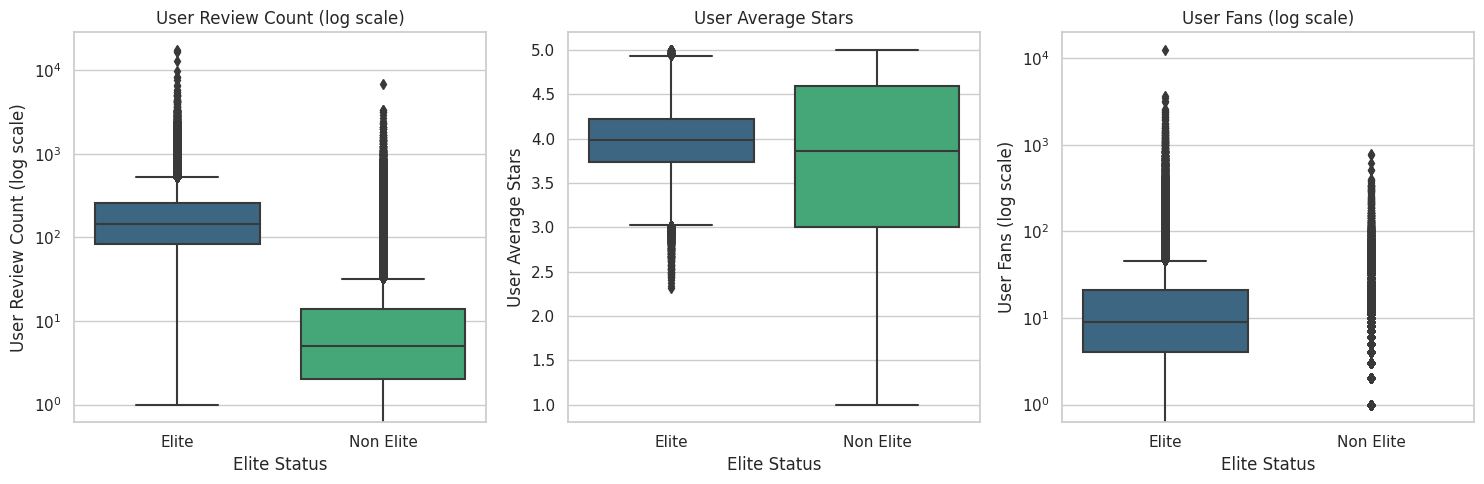

In [12]:
# Comparing user metrics between Elite and Non-Elite users 

selected_columns = [
    "user_review_count", 
    "user_average_stars", 
    "user_fans", 
    "user_elite_years_count"
]

elite_df = df.select(*selected_columns).toPandas()
elite_df['is_elite'] = np.where(elite_df['user_elite_years_count'] > 0, 'Elite', 'Non Elite')

sns.set(style='whitegrid')
plt.figure(figsize=(15, 5))

# Plot 1: Boxplot for user_review_count
plt.subplot(1, 3, 1)
sns.boxplot(x='is_elite', y='user_review_count', data=elite_df, palette='viridis')
plt.yscale('log')
plt.title('User Review Count (log scale)')
plt.ylabel('User Review Count (log scale)')
plt.xlabel('Elite Status')

# Plot 2: Boxplot for user_average_stars
plt.subplot(1, 3, 2)
sns.boxplot(x='is_elite', y='user_average_stars', data=elite_df, palette='viridis')
plt.title('User Average Stars')
plt.ylabel('User Average Stars')
plt.xlabel('Elite Status')

# Plot 3: Boxplot for user_fans
plt.subplot(1, 3, 3)
sns.boxplot(x='is_elite', y='user_fans', data=elite_df, palette='viridis')
plt.yscale('log')
plt.title('User Fans (log scale)')
plt.ylabel('User Fans (log scale)')
plt.xlabel('Elite Status')

plt.tight_layout()
plt.show()

These boxplots offer the following insights:

* **User Review Count**: As seen previously, elite users tend to have higher median review counts compared to non-elite users, indicating a potentially more active engagement in contributing reviews to Yelp. The spread of review counts is also wider among elite users, with some displaying significantly higher levels of user-generated content.

* **User Average Stars**: Elite users exhibit a slightly higher median average star rating compared to non-elite users, suggesting that recognized contributors tend to provide reviews with slightly higher star ratings on average.

* **User Fans**: Elite users tend to have a higher median number of fans, indicating a stronger presence and influence within the Yelp community. The spread of fan counts is notably wider among elite users, with some having a substantial fan following

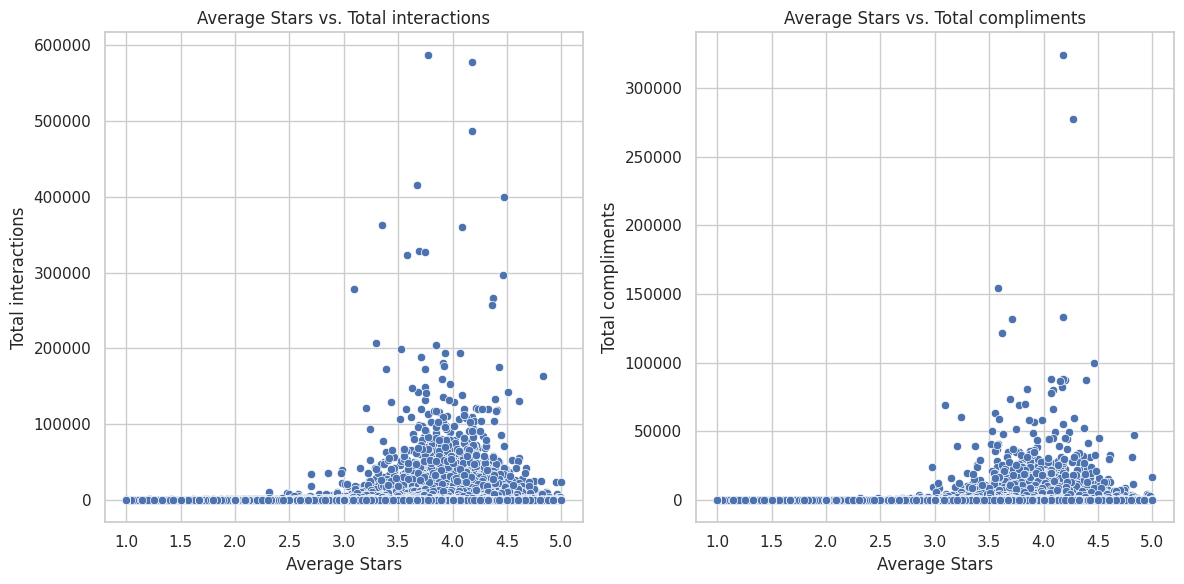

In [13]:
# Exploring the relationship of User Average Stars with User Interactions and User Compliments

selected_columns = [
    "user_average_stars", 
    "user_total_interactions", 
    "user_total_compliments"
]

user_interaction_data = df.select(selected_columns).toPandas()

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

metrics = ['user_total_interactions', 'user_total_compliments']

for i, metric in enumerate(metrics, 1):
    plt.subplot(1, len(metrics), i)
    sns.scatterplot(x='user_average_stars', y=metric, data=user_interaction_data)
    plt.title(f'Average Stars vs. {metric.replace("user_total_", "Total ")}')
    plt.xlabel('Average Stars')
    plt.ylabel(metric.replace("user_total_", "Total "))

plt.tight_layout()
plt.show()

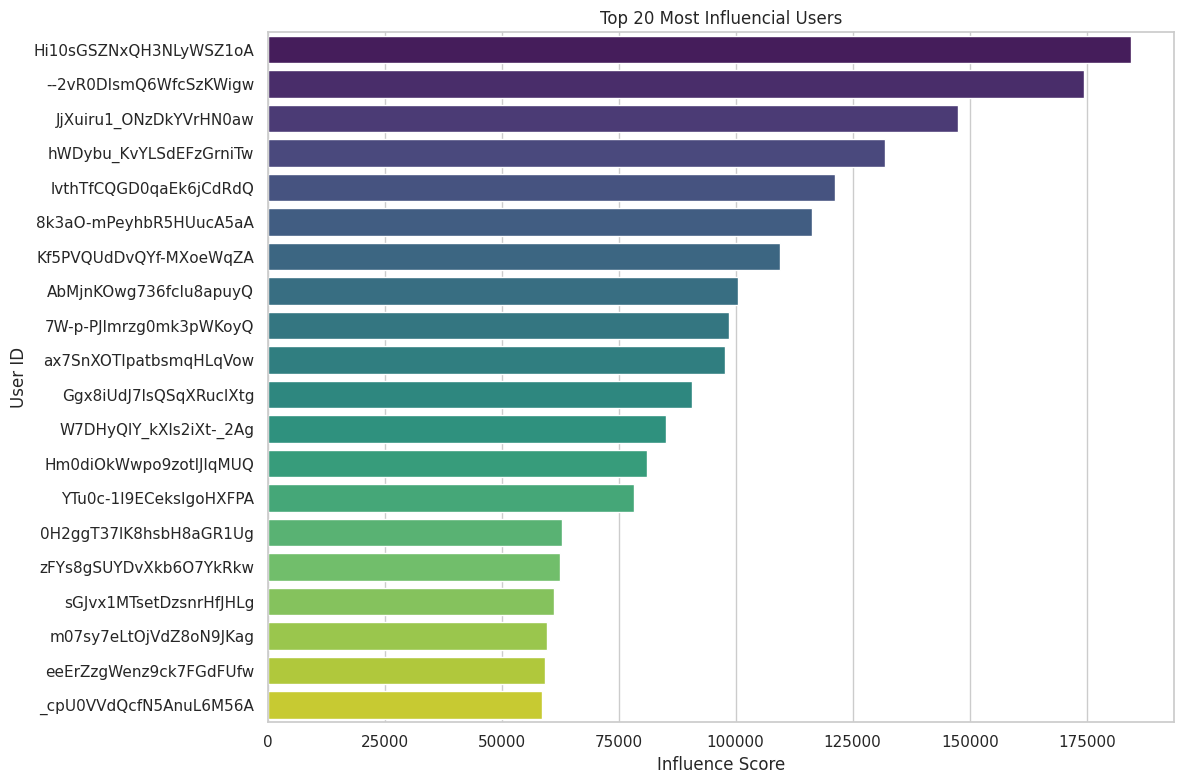

In [14]:
# Calculating user influence scores based on review count, fans, and interactions, and visualizing the top 20 most influential users.

def calculate_user_influence(row):
    review_weight = 0.4
    fans_weight = 0.3
    interactions_weight = 0.3
    
    influence_score = (
        row['user_review_count'] * review_weight +
        row['user_fans'] * fans_weight +
        row['user_total_interactions'] * interactions_weight
    )
    
    return influence_score


user_influence_df = df.select('user_id', 'user_review_count', 'user_fans', 'user_total_interactions').toPandas()
user_influence_df['user_influence_score'] = user_influence_df.apply(calculate_user_influence, axis=1)
user_influence_df = user_influence_df.sort_values(by='user_influence_score', ascending=False)

top_20_influential_users = user_influence_df.head(20)

sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

sns.barplot(x='user_influence_score', y='user_id', data=top_20_influential_users, palette='viridis')
plt.title('Top 20 Most Influencial Users')
plt.xlabel('Influence Score')
plt.ylabel('User ID')

plt.tight_layout()
plt.show()